# Градиентный спуск

В этом домашнем задании вы напишете градиентный спуск для линейной регрессии, а так же посмотрите, как он ведёт себя с разными параметрами и разными функциями потерь.

Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек.  

In [237]:
import abc

import matplotlib.pyplot as plt
import numpy as np

## Часть 1. Градиентный спуск (5 баллов)

Для обучения линейной регрессии необходим функционал ошибки, определим интерфейс для последующих реализаций.

In [238]:
class BaseLoss(abc.ABC):
    """Base class for losses"""

    @abc.abstractmethod
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        """Calculate loss value based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            number, loss value
        """
        raise NotImplementedError

    @abc.abstractmethod
    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        """Calculate gradient vector based on inputs and weights

        Args:
            X: array with dataset objects, (n_samples, n_features)
            y: array with ground truth values, (n_samples,)
            w: linear regression weights, (n_features,)

        Returns:
            gradients for weights, (n_features,)
        """
        raise NotImplementedError

Вспомним самый простой функционал ошибки, который мы применяем в задаче регрессии — Mean Squared Error:

$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2
$$

где $x_i$ — это $i$-ый объект датасета, $y_i$ — правильный ответ для $i$-го объекта, а $w$ — веса нашей линейной модели.

Как мы помним, для линейной модели, его можно записать в матричном виде вот так:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2
$$

где $X$ — это матрица объекты-признаки, а $y$ — вектор правильных ответов

Для того чтобы воспользоваться методом градиентного спуска, нам нужно посчитать градиент нашего функционала. Для MSE он будет выглядеть так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y)
$$

In [239]:
class MSELoss(BaseLoss):
    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        return np.mean((X @ w - y) ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        return (2 / len(y)) * (X.T @ (X @ w - y))

In [240]:
# Проведем небольшую проверку реализации

# Создадим объект лосса
loss = MSELoss()

# Создадим какой-то датасет
X = np.arange(200).reshape(20, 10)
y = np.arange(20)

# Создадим какой-то вектор весов
w = np.arange(10)

# Выведем значение лосса и градиента на этом датасете с этим вектором весов
print(loss.calc_loss(X, y, w))
print(loss.calc_grad(X, y, w))

# Проверка, что методы реализованы правильно
assert loss.calc_loss(X, y, w) == 27410283.5, "Метод calc_loss реализован неверно"
assert np.allclose(
    loss.calc_grad(X, y, w),
    np.array(
        [
            1163180.0,
            1172281.0,
            1181382.0,
            1190483.0,
            1199584.0,
            1208685.0,
            1217786.0,
            1226887.0,
            1235988.0,
            1245089.0,
        ]
    ),
), "Метод calc_grad реализован неверно"
print("Всё верно!")

27410283.5
[1163180. 1172281. 1181382. 1190483. 1199584. 1208685. 1217786. 1226887.
 1235988. 1245089.]
Всё верно!


Теперь когда у нас есть всё для вычисления градиента, давайте напишем наш градиентный спуск. Напомним, что формула для одной итерации градиентного спуска выглядит следующим образом:

$$
w^t = w^{t-1} - \eta \nabla_{w} Q(w^{t-1}, X, y)
$$

Где $w^t$ — значение вектора весов на $t$-ой итерации, а $\eta$ — параметр learning rate, отвечающий за размер шага.

In [241]:
def gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    n_iterations: int = 100000,
) -> np.ndarray:
    """Weights optimization with gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    w = w_init.copy()
    w_history = np.zeros((n_iterations, w.shape[0]))
    w_history[0] = w

    for t in range(1, n_iterations):
        w -= lr * loss.calc_grad(X, y, w)
        w_history[t] = w
    
    return w_history

Теперь создадим синтетический датасет и функцию, которая будет рисовать траекторию градиентного спуска по истории:

In [242]:
# Создаём датасет из двух переменных и реального вектора зависимости w_true

np.random.seed(1337)

n_features = 2
n_objects = 300
batch_size = 10
num_steps = 43

w_true = np.random.normal(size=(n_features,))

X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]
y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_init = np.random.uniform(-2, 2, (n_features))

print(X.shape)
print(y.shape)

(300, 2)
(300,)


In [243]:
loss = MSELoss()
w_list = gradient_descent(w_init, X, y, loss, 0.01, 100)
print(loss.calc_loss(X, y, w_list[0]))
print(loss.calc_loss(X, y, w_list[-1]))

425.58917680450253
0.8670644395649652


In [244]:
def plot_gd(w_list: np.ndarray, X: np.ndarray, y: np.ndarray, loss: BaseLoss, ax=None):
    """Plot gradient descent trajectory

    Args:
        w_list: weights history, (n_iterations, n_features)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
    """

    if ax is None:
        ax = plt.gca()

    w_list = np.array(w_list)
    meshgrid_space = np.linspace(-2, 2, 100)
    A, B = np.meshgrid(meshgrid_space, meshgrid_space)

    levels = np.empty_like(A)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            w_tmp = np.array([A[i, j], B[i, j]])
            levels[i, j] = loss.calc_loss(X, y, w_tmp)

    ax.set_title("GD trajectory")
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    ax.set_xlim(w_list[:, 0].min() - 0.1, w_list[:, 0].max() + 0.1)
    ax.set_ylim(w_list[:, 1].min() - 0.1, w_list[:, 1].max() + 0.1)
    ax.set_aspect("equal")

    # visualize the level set
    CS = ax.contour(A, B, levels, levels=np.logspace(0, 1, num=20), cmap=plt.cm.rainbow_r)
    CB = plt.colorbar(CS, ax=ax, shrink=0.8, extend="both")

    # visualize trajectory
    ax.scatter(w_list[:, 0], w_list[:, 1])
    ax.plot(w_list[:, 0], w_list[:, 1])

При помощи функций `gradient_descent` и  `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`). Используйте не менее четырёх разных значений для `lr`. Хорошие значения для `lr` могут лежать в промежутке от 0.0001 до 0.1

Сделайте и опишите свои выводы о том, как параметр `lr` влияет на поведение градиентного спуска

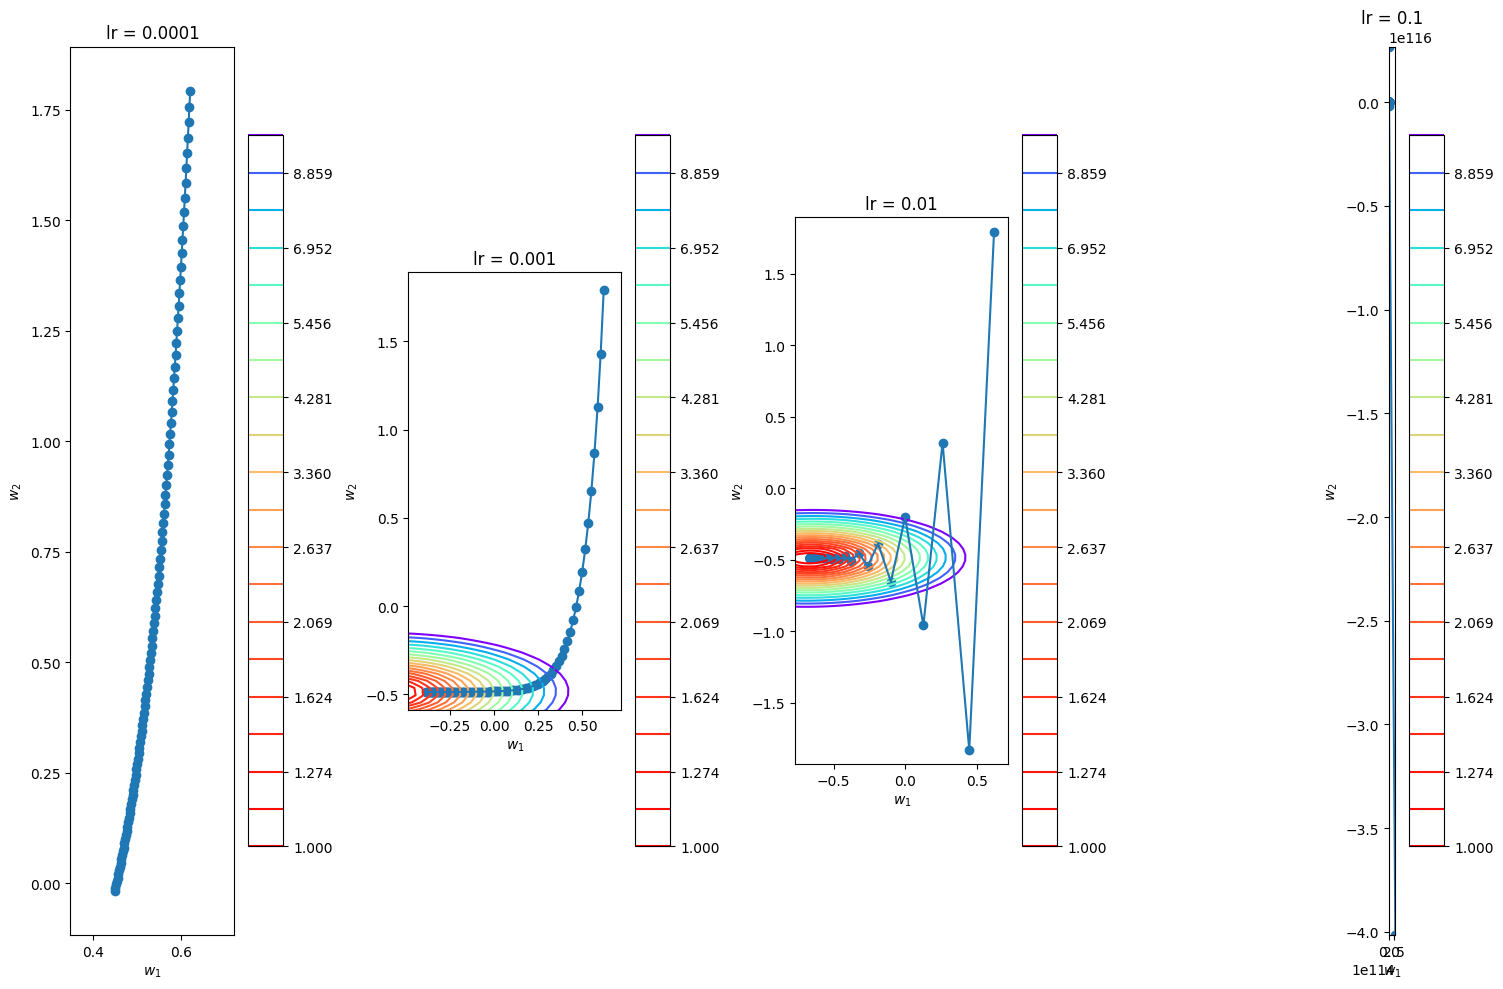

In [245]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]

fig, axes = plt.subplots(1, len(learning_rates), figsize=(15,10))

for i, lr in enumerate(learning_rates):
    w_list = gradient_descent(w_init, X, y, loss, lr, 100)
    ax = axes[i]
    plot_gd(w_list, X, y, loss, ax)
    ax.set_title(f"lr = {lr}")

plt.tight_layout()
plt.show()

**Ответ:** С самым маленьким lr веса изменяются очень медленно из-за чего модели нужно больше итераций, чтобы достичь минимума, но он более стабильный. Если же взять слишком большой lr, то в начале он будет двигаться быстро, но затем будет "перескакивать" нужное значение и будет расходится. Оптимально нужно выбрать такое значение, чтобы он обеспечивал быструю сходимость, но это требует подбора. Хорошей тактикой будет взять небольшое значение и постепенно его увеличивать, смотря что происходит

Теперь реализуем стохастический градиентный спуск. Функция должна принимать все те же параметры, что и функция `gradient_descent`, но ещё параметр `batch_size`, отвечающий за размер батча.

Функция должна как и раньше реализовывать цикл, в котором происходит шаг градиентного спуска, но на каждом шаге считать градиент не по всей выборке `X`, а только по случайно выбранной части.

Подсказка: для выбора случайной части можно использовать [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html) с правильным параметром `size`, чтобы выбрать случайные индексы, а потом проиндексировать получившимся массивом массив `X`:
```
batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
batch = X[batch_indices]
```

In [246]:
def stochastic_gradient_descent(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with stochastic gradient descent

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    np.random.seed(42)
    w = w_init.copy()
    w_history = np.zeros((n_iterations, w.shape[0]))
    w_history[0] = w

    for t in range(1, n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]

        w -= lr * loss.calc_grad(X_batch, y_batch, w)
        w_history[t] = w

    return w_history

При помощи функций `stochastic_gradient_descent` и `plot_gd` нарисуйте траекторию градиентного спуска для разных значений длины шага (параметра `lr`) и размера подвыборки (параметра `batch_size`). Используйте не менее четырёх разных значений для `lr` и `batch_size`.

Сделайте и опишите свои выводы о том, как параметры `lr` и `batch_size` влияют на поведение стохастического градиентного спуска. Как отличается поведение стохастического градиентного спуска от обычного?

Обратите внимание, что в нашем датасете всего 300 объектов, так что `batch_size` больше этого числа не будет иметь смысла.

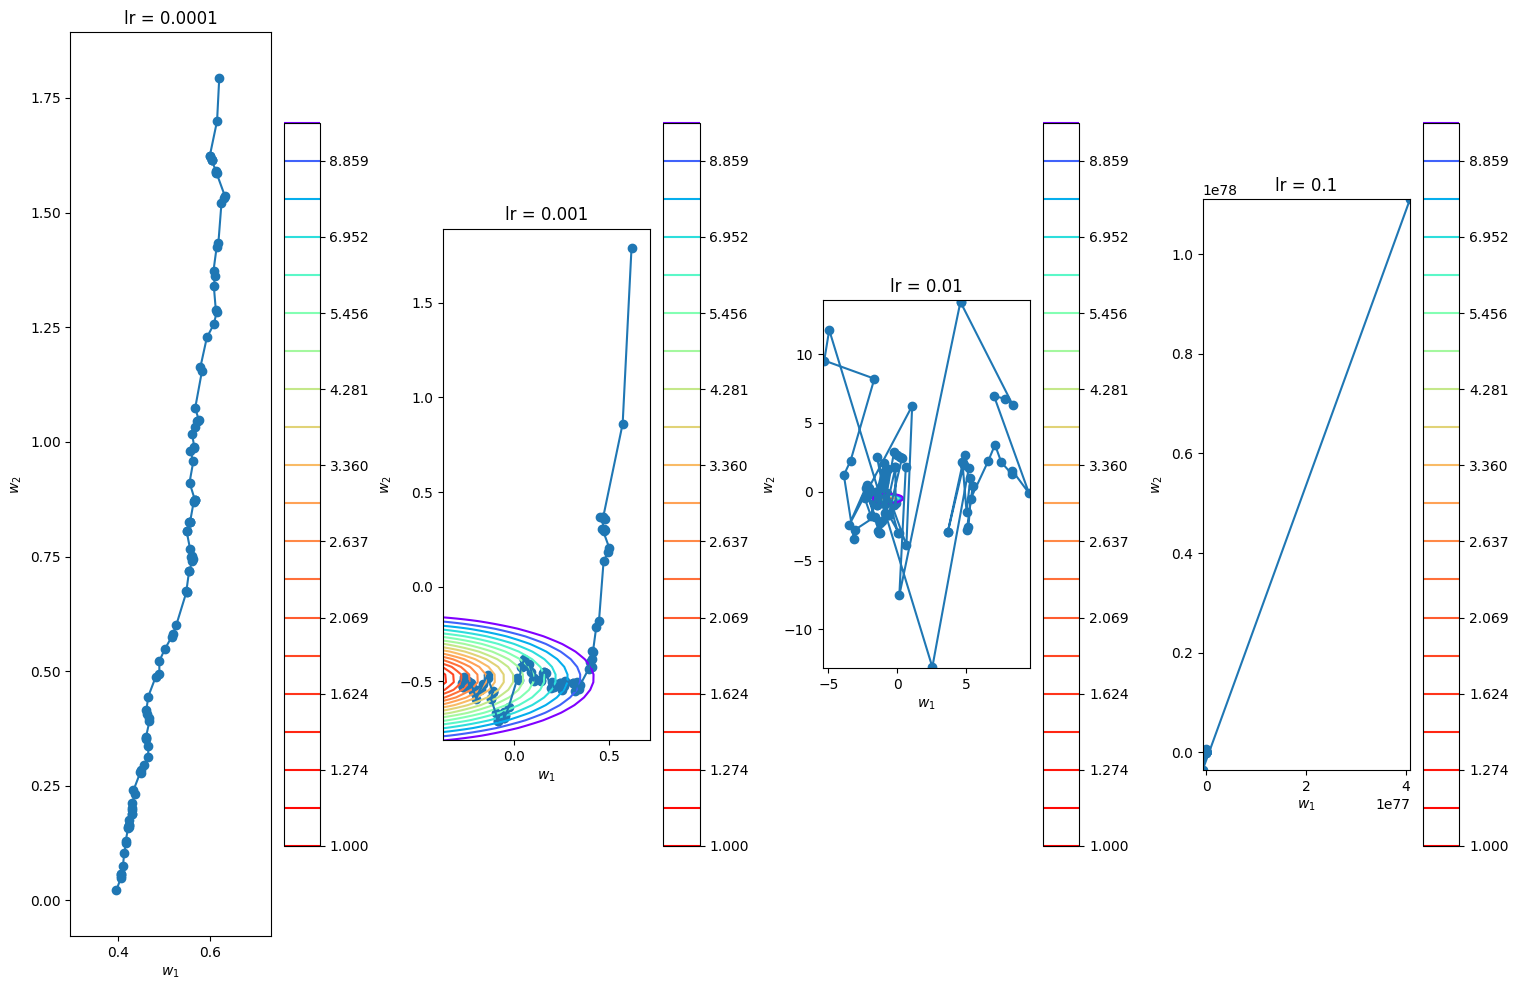

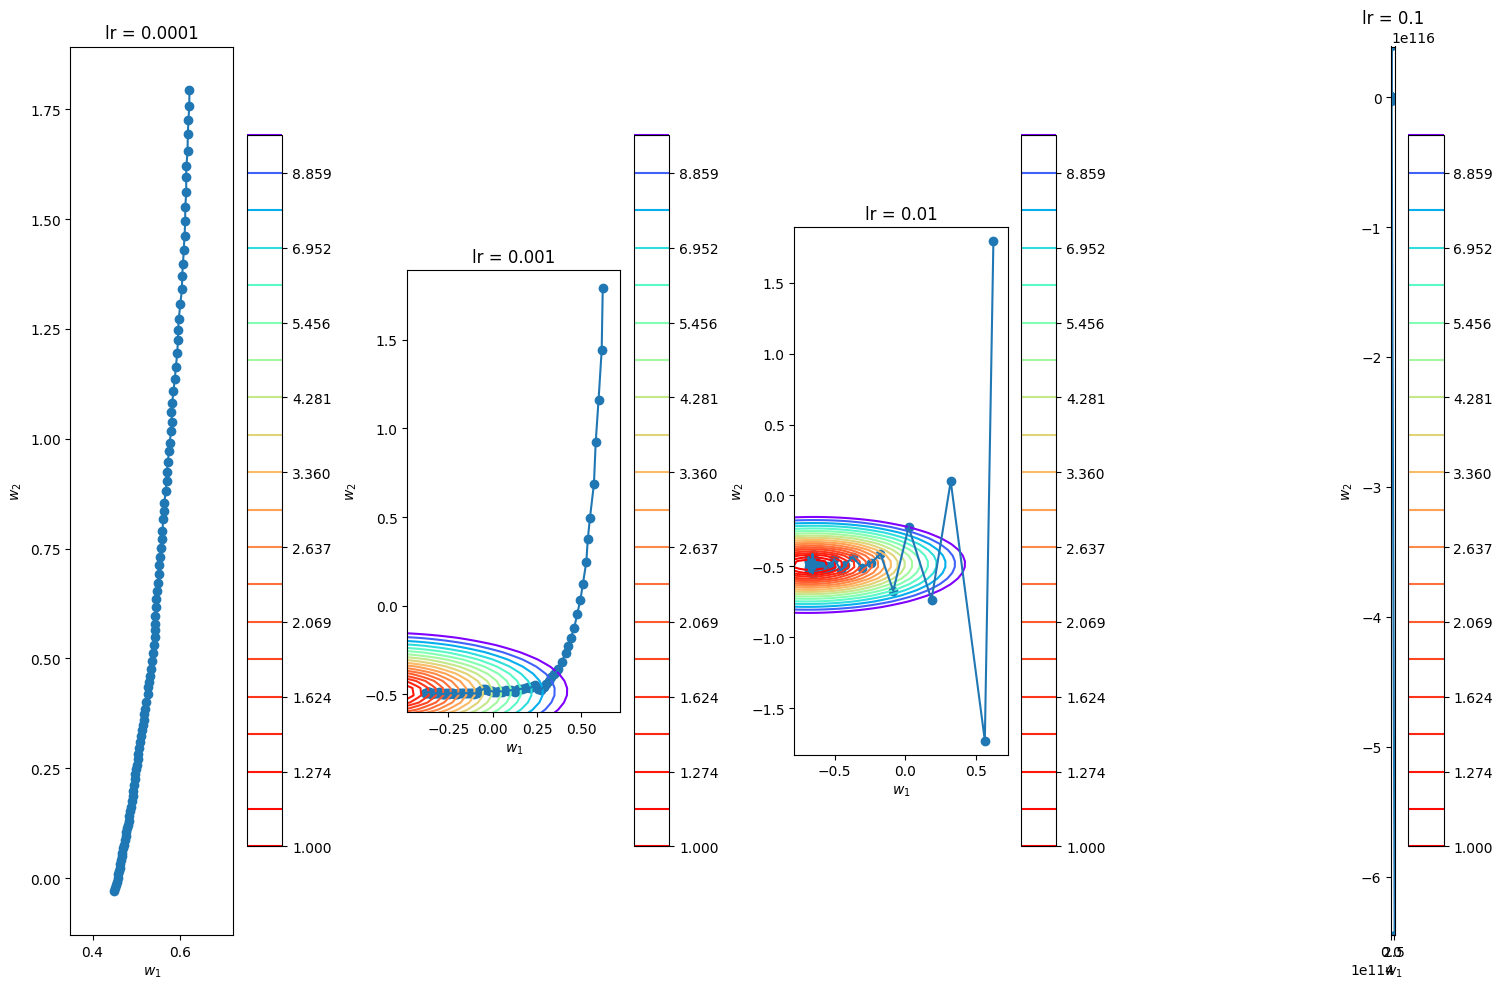

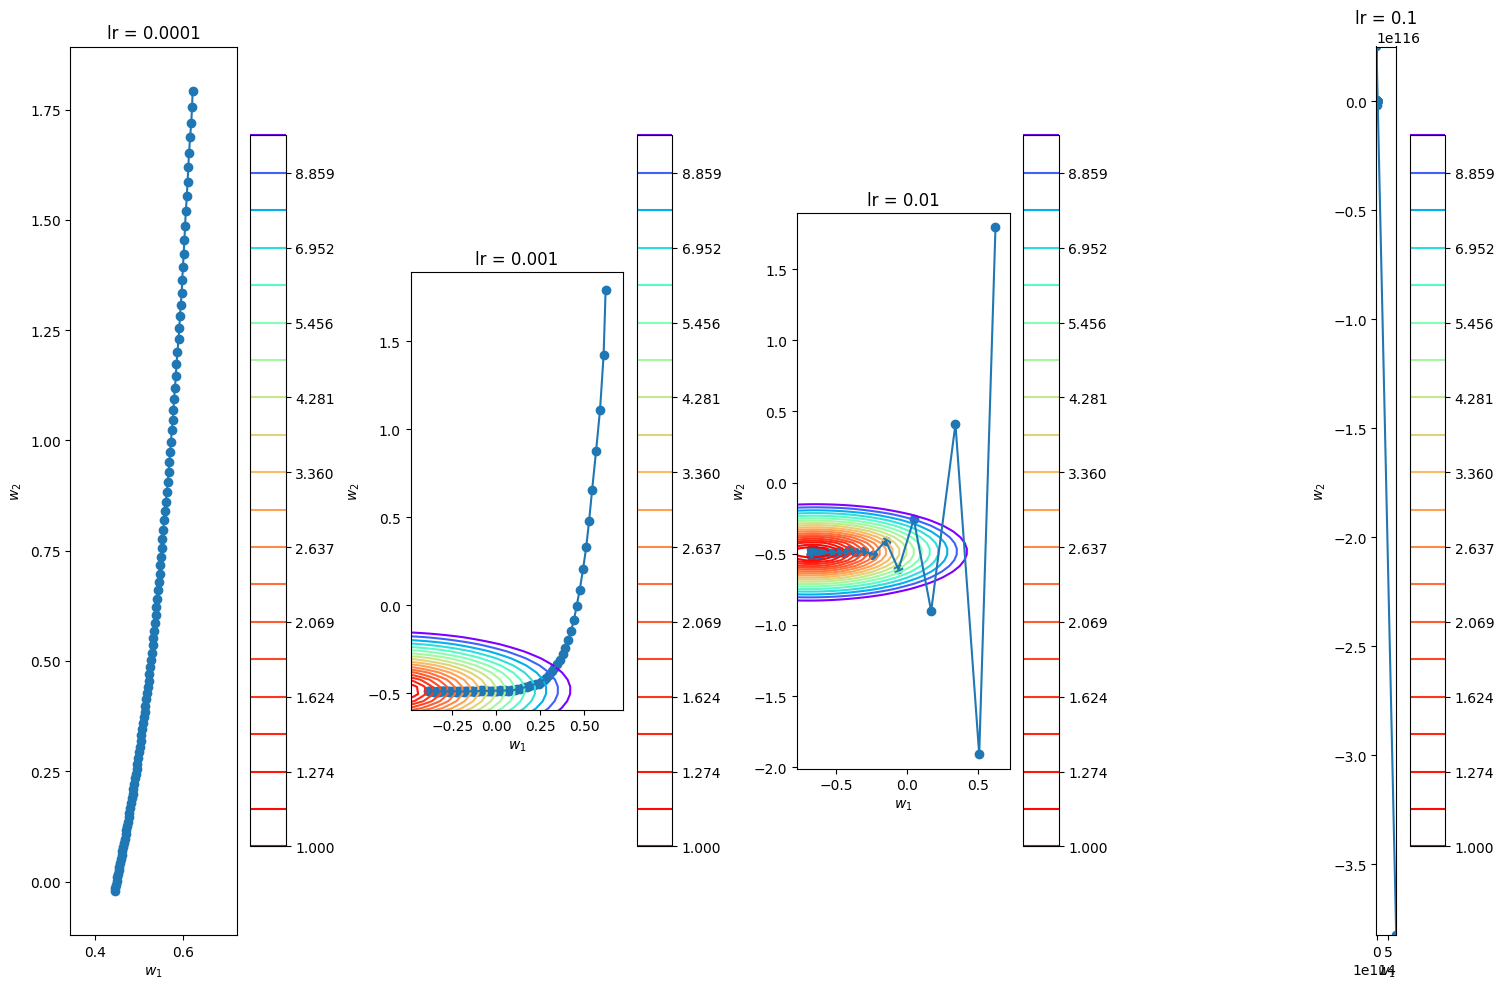

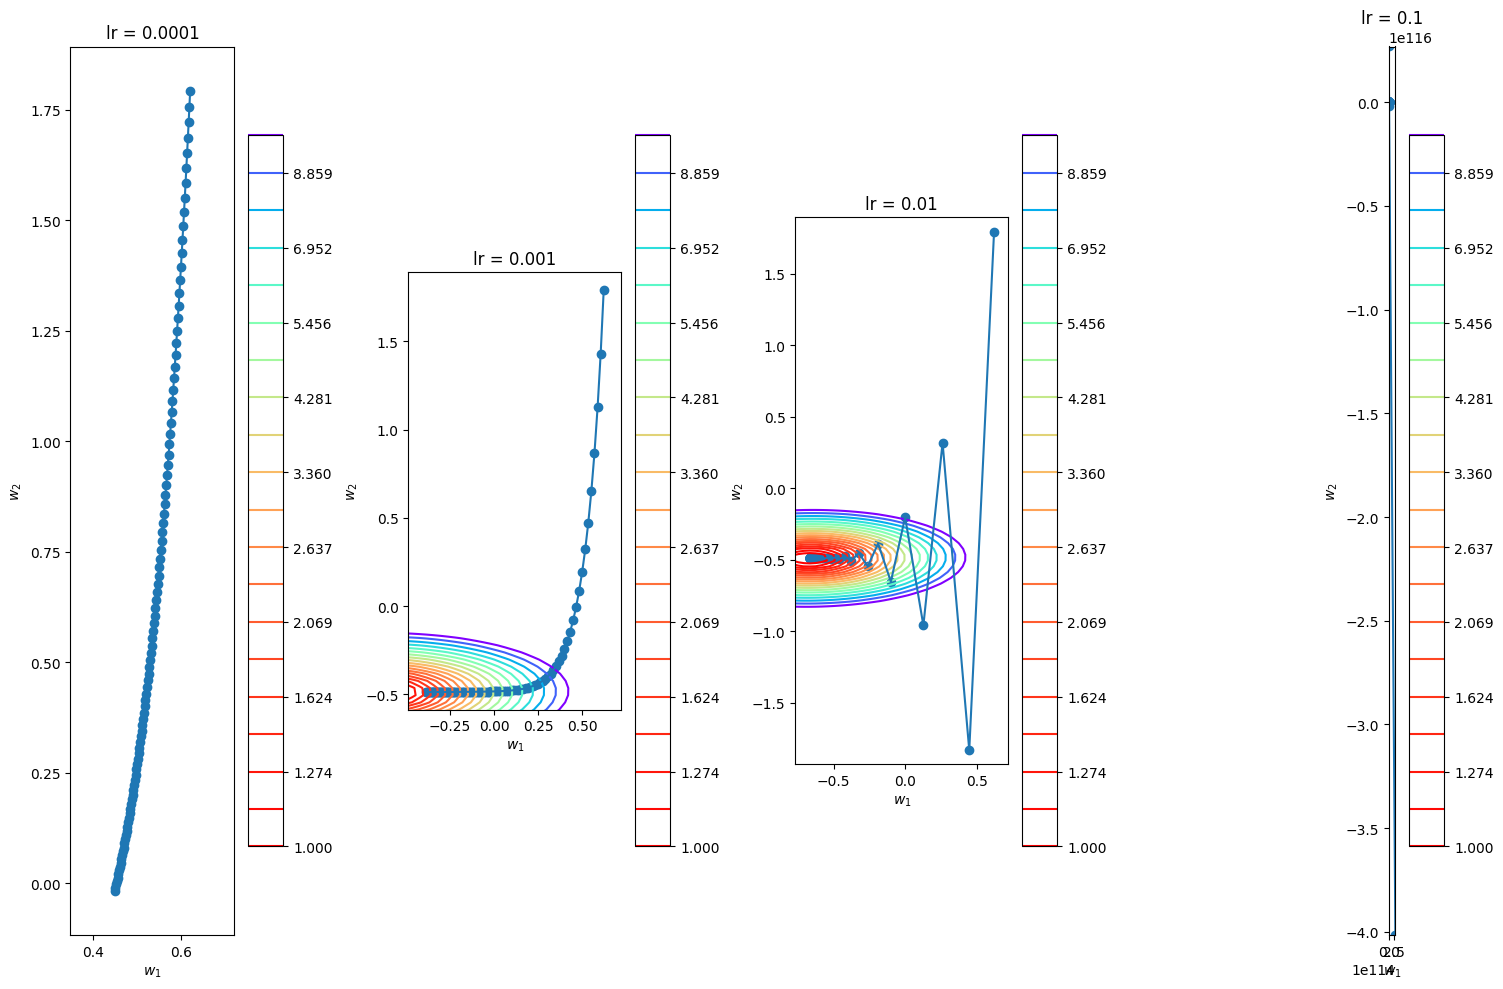

In [247]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [1, 50, 150, 300]

for batch_size in batch_sizes:
    fig, axes = plt.subplots(1, len(learning_rates), figsize=(15,10))
    for i, lr in enumerate(learning_rates):
        w_list = stochastic_gradient_descent(w_init, X, y, loss, lr, batch_size, 100)
        ax = axes[i]
        plot_gd(w_list, X, y, loss, ax)
        ax.set_title(f"lr = {lr}")

    plt.tight_layout()
    plt.show()

**Ответ:** Параметр lr как и в обычном спуске влияет на скорость и стабильность, а вот batch_size влияет на некую предсказуемость в направлении, то есть при маленьком размере повышается шум и некоторые направления кажутся случайными и не предсказуемыми, если сравнивать с графиками с бОльшим значением, но так же это может помочь избежать проблемы с локальным минимумом и уменьшает затраты на обучение, а большой размер батчек уменьшает разброс направлений, но и более вычислительно затратный. Так же можно заметить, что если размер батча не большой, то lr стоить выбирать небольшим, так как иначе движения становятся слишком хаотичными. Как итог, стохастический градиентый спуск очень полезен на больших данных, где обычный работал бы очень долго, но он требует еще более тщательного подбора параметров

Вы могли заметить, что поведение градиентного спуска, особенно стохастической версии, очень сильно зависит от размера шага.

Как правило, в начале спуска мы хотим делать большие шаги, чтобы поскорее подойти поближе к минимуму, а позже мы уже хотим делать шаги маленькие, чтобы более точнее этого минимума достичь и не "перепрыгнуть" его.

Чтобы достичь такого поведения мы можем постепенно уменьшать длину шага с увеличением номера итерации. Сделать это можно, например, вычисляя на каждой итерации длину шага по следующей формуле:

$$
    \eta_t
    =
    \lambda
    \left(
        \frac{s_0}{s_0 + t}
    \right)^p
$$

где $\eta_t$ — длина шага на итерации $t$, $\lambda$ — начальная длина шага (параметр `lr` у нас), $s_0$ и $p$ — настраиваемые параметры.

Реализуйте SGD на этот раз с затухающим шагом по формуле выше. Параметр $s_0$ возьмите равным 1. Параметр $p$ возьмите из нового аргумента функции `p`.

In [248]:
def stochastic_gradient_descent_with_decay(
    w_init: np.ndarray,
    X: np.ndarray,
    y: np.ndarray,
    loss: BaseLoss,
    lr: float,
    batch_size: int,
    p: float,
    n_iterations: int = 1000,
) -> np.ndarray:
    """Weights optimization with SGD and learning rate decay

    Args:
        w_init: initial weights, (n_features,)
        X: array with dataset objects, (n_samples, n_features)
        y: array with ground truth values, (n_samples,)
        loss: BaseLoss instance to calculate loss and gradients
        lr: learning rate, float
        batch_size: number of samples in each batch, int
        p: learning rate decay factor, float
        n_iterations: number of iterations, int

    Returns:
        History of weights on each step, (n_iterations, n_features)
    """
    np.random.seed(42)
    w = w_init.copy()
    w_history = np.zeros((n_iterations, w.shape[0]))
    w_history[0] = w
    s0 = 1

    for t in range(1, n_iterations):
        batch_indices = np.random.choice(X.shape[0], size=batch_size, replace=False)
        X_batch = X[batch_indices]
        y_batch = y[batch_indices]

        lr_t = lr * (s0 / (s0 + t)) ** p
        w -= lr_t * loss.calc_grad(X_batch, y_batch, w)
        w_history[t] = w
    
    return w_history

При помощи новой функции `stochastic_gradient_descent_with_decay` и функции `plot_gd` нарисуйте траекторию градиентного спуска для разных значений параметра `p`. Используйте не менее четырёх разных значений для `p`. Хорошими могут быть значения, лежащие в промежутке от 0.1 до 1.
Параметр `lr` возьмите равным 0.01, а параметр `batch_size` равным 10.

Сделайте и опишите свои выводы о том, как параметр `p` влияет на поведение стохастического градиентного спуска

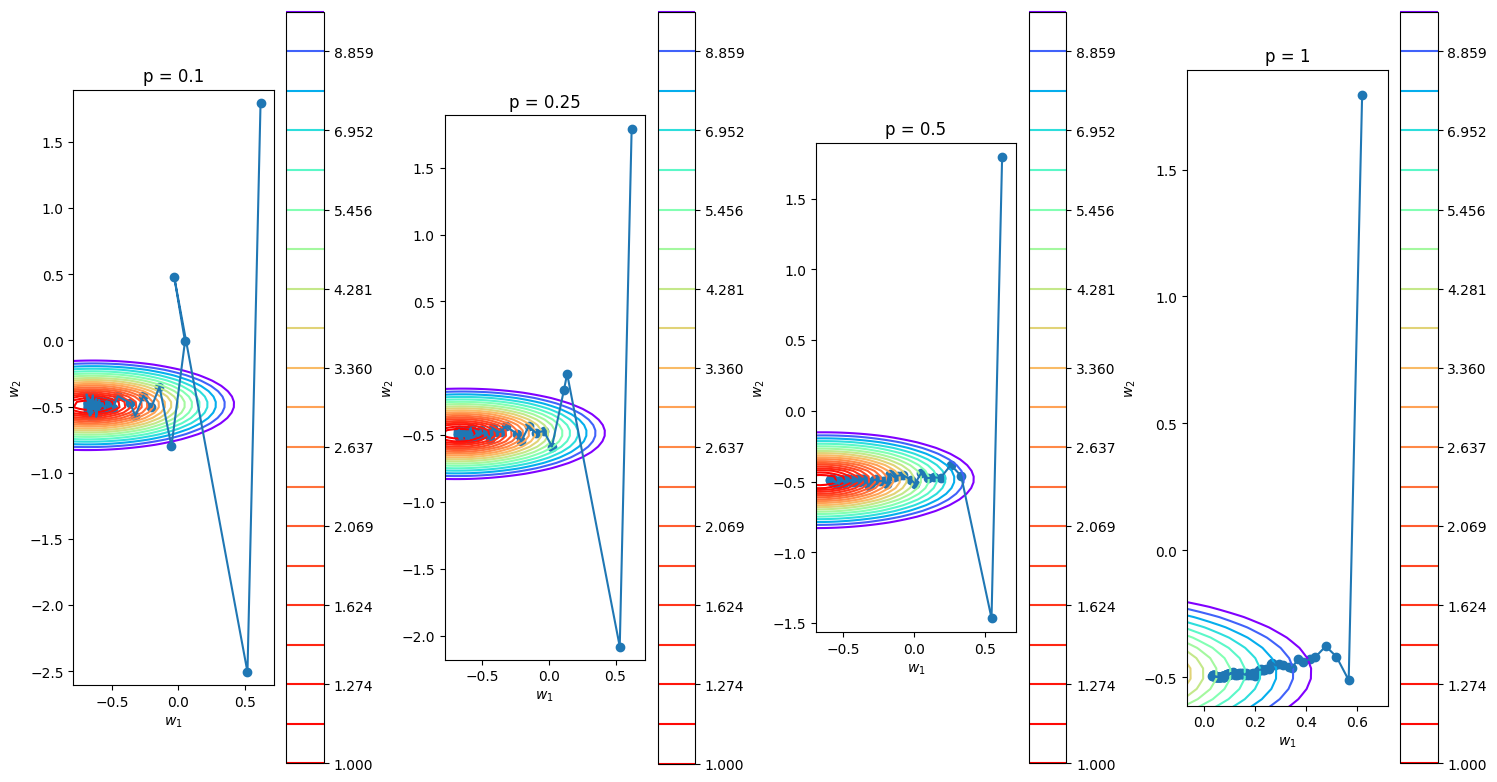

In [249]:
p_values = [0.1, 0.25, 0.5, 1]

fig, axes = plt.subplots(1, len(p_values), figsize=(15,10))

for i, p in enumerate(p_values):
    w_list = stochastic_gradient_descent_with_decay(w_init, X, y, loss, 0.01, 10, p, 100)
    ax = axes[i]
    plot_gd(w_list, X, y, loss, ax)
    ax.set_title(f"p = {p}")

plt.tight_layout()
plt.show()

Сравните сходимость обычного градиентного спуска и стохастичекой версии:
Нарисуйте график зависимости значения лосса (его можно посчитать при помощи метода `calc_loss`, используя $x$ и $y$ из датасета и $w$ с соответствующей итерации) от номера итерации для траекторий, полученных при помощи обычного и стохастического градиентного спуска с одинаковыми параметрами. Параметр `batch_size` возьмите равным 10.

Видно ли на данном графике преимущество SGD? Почему?

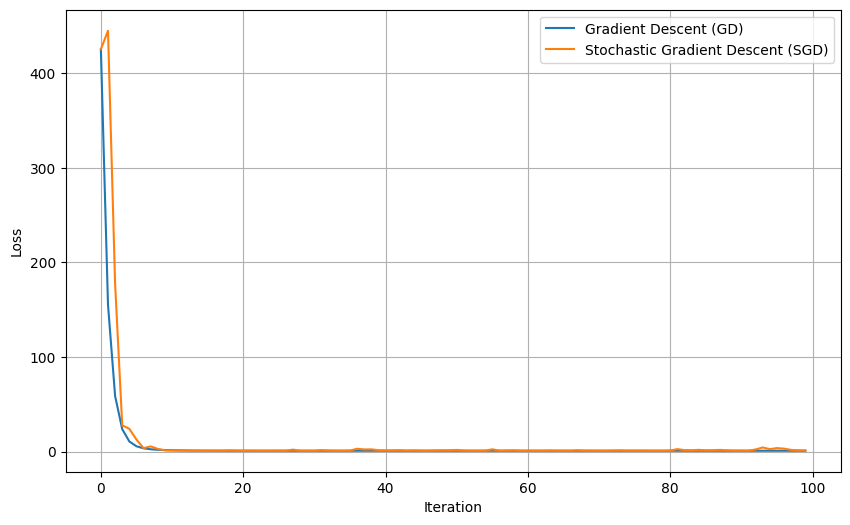

In [250]:
w_list_gd = gradient_descent(w_init, X, y, loss, 0.01, 100)
w_list_sgd = stochastic_gradient_descent(w_init, X, y, loss, 0.01, 10, 100)

loss_gd = [loss.calc_loss(X, y, w) for w in w_list_gd]
loss_sgd = [loss.calc_loss(X, y, w) for w in w_list_sgd]

plt.figure(figsize=(10, 6))
plt.plot(loss_gd, label="Gradient Descent (GD)")
plt.plot(loss_sgd, label="Stochastic Gradient Descent (SGD)")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

**Ответ:** На графике видно, что GD более гладкая, чем SGD, но главное преимущество SGD это уменьшение вычислений, что не видно на графике

## Часть 2. Линейная регрессия (5 баллов)

Напишем наш класс для линейной регрессии. Он будет использовать интерфейс, знакомый нам из библиотеки `sklearn`.

В методе `fit` мы будем подбирать веса `w` при помощи градиентного спуска нашим методом `gradient_descent`. Не забывайте про единичный признак!

В методе `predict` мы будем применять нашу регрессию к датасету,

In [251]:
class LinearRegression:
    def __init__(self, loss: BaseLoss, lr: float = 0.1) -> None:
        self.loss = loss
        self.lr = lr
        self.w = None

    def fit(self, X: np.ndarray, y: np.ndarray) -> "LinearRegression":
        X = np.asarray(X)
        y = np.asarray(y)

        X_bias = np.c_[np.ones(X.shape[0]), X]

        n_features = X_bias.shape[1]
        w_init = np.random.normal(size=(n_features, ))

        w_history = gradient_descent(w_init, X_bias, y, self.loss, self.lr, 100)
        self.w = w_history[-1]

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        # Проверяем, что регрессия обучена, то есть, что был вызван fit и в нём был установлен атрибут self.w
        assert hasattr(self, "w"), "Linear regression must be fitted first"
        
        X = np.asarray(X)
        X_bias = np.c_[np.ones(X.shape[0]), X]

        return X_bias @ self.w

Теперь у нас есть наш класс линейной регрессии. Более того, мы можем управлять тем, какую функцию потерь мы оптимизируем, просто передавая разные классы в параметр `loss` при инициализации.

Пока у нас нет никаких классов кроме `MSELoss`, но скоро они появятся.

Для `MSELoss` мы бы создавали наш объект линейной регрессии, например, так:

In [252]:
linear_regression = LinearRegression(MSELoss())

Применим нашу регрессию на реальном датасете. Загрузим датасет с машинами, который был у вас на семинарах:

In [253]:
import pandas as pd

X_raw = pd.read_csv(
    "http://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)
X_raw = X_raw[~X_raw[25].isna()].reset_index()
X_raw.columns = X_raw.columns.astype(str)

In [254]:
X_raw.head()

,index,0,1,2,3,4,5,6,7,8,...,16,17,18,19,20,21,22,23,24,25
0,0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,...,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,...,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,3,2,164.0,audi,gas,std,four,sedan,fwd,front,...,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,4,2,164.0,audi,gas,std,four,sedan,4wd,front,...,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [255]:
y = X_raw["25"]
X_raw = X_raw.drop("25", axis=1)

Как обычно обработайте датасет всеми нужными методами, чтобы на нём можно было обучать линейную регрессию:

* Разделите датасет на обучающую и тестовую выборку
* Заполните пропуски
* Нормализуйте числовые признаки
* Закодируйте категориальные переменные

In [256]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

In [257]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = X_raw.select_dtypes(include=["number"]).columns
categorical_features = X_raw.select_dtypes(exclude=["number"]).columns

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="NotGiven")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, numeric_features),
        ("categorical", categorical_transformer, categorical_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)


Обучите линейную регрессию на обучающей выборке

In [258]:
linear_regression.fit(X_train, y_train)

Для оценки качества реализуем `r2_score`, который является нормализацией `mean_square_error`.

In [259]:
def r2(y_true: np.ndarray, y_predicted: np.ndarray) -> float:
    y_mean = np.mean(y_true)
    tss = np.sum((y_true - y_mean) ** 2)
    rss = np.sum((y_true - y_predicted) ** 2)
    r2_score = 1 - (rss / tss)
    return r2_score

Посчитайте ошибку обученной регрессии на обучающей и тестовой выборке.

In [260]:
y_train_pred = linear_regression.predict(X_train)
y_test_pred = linear_regression.predict(X_test)

r2_train = r2(y_train, y_train_pred)
r2_test = r2(y_test, y_test_pred)

print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

Train R2: 0.922784525542079
Test R2: 0.8778581356426635


Наша модель переобучилась. Давайте как обычно в такой ситуации добавим к ней L2 регуляризацию. Для этого нам нужно написать новый класс лосса.

Формула функции потерь для MSE с L2 регуляризацией выглядит так:
$$
Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell (\langle x_i, w \rangle - y_i)^2 + \lambda ||w||^2
$$

Или в матричном виде:

$$
Q(w, X, y) = \frac{1}{\ell} || Xw - y ||^2 + \lambda ||w||^2
$$

Где $\lambda$ — коэффициент регуляризации

Градиент выглядит так:

$$
\nabla_w Q(w, X, y) = \frac{2}{\ell} X^T(Xw-y) + 2 \lambda w
$$

Обратите внимание, что последний элемент вектора `w` — это bias (в классе `LinearRegression` к матрице `X` добавляется колонка из единиц — константный признак).

**Вопрос**: надо ли регуляризовывать bias?

**Ответ**: Нет, так как он отвечает за смещение и его ограничение может привести к смещению предсказаний и ухудшению результатов

Не забудьте убрать последний элемент из `w` при подсчёте слагаемого $\lambda||w||^2$ в `calc_loss` и занулить его при подсчёте слагаемого $2 \lambda w$ в `calc_grad`

In [261]:
class MSEL2Loss(BaseLoss):
    def __init__(self, coef: float = 1.0):
        self.coef = coef

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        mse = np.mean((X @ w - y) ** 2)
        return mse + self.coef * np.sum(w[:-1] ** 2)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        mse_grad = (2 / len(y)) * (X.T @ (X @ w - y))
        l2_grad = 2 * self.coef * w
        l2_grad[-1] = 0
        return mse_grad + l2_grad

Теперь мы можем использовать лосс с l2 регуляризацией в нашей регрессии, например, так:

In [262]:
linear_regression = LinearRegression(MSEL2Loss(0.1))

Обучите регрессию с лоссом `MSEL2Loss`. Подберите хороший коэффициент регуляризации и добейтесь улучшения результата на тестовой выборке. Сравните результат на обучающей и тестовой выборке с регрессией без регуляризации.

In [263]:
lambda_values = [0.01, 0.1, 1.0, 10.0, 100.0]
best_lambda = None
best_r2 = -np.inf

for lambda_val in lambda_values:
    l2_loss = MSEL2Loss(coef=lambda_val)
    linear_regression = LinearRegression(l2_loss)

    linear_regression.fit(X_train, y_train)
    y_test_pred = linear_regression.predict(X_test)
    r2_tester = r2(y_test, y_test_pred)

    if r2_tester > best_r2:
        best_r2 = r2_tester
        best_lambda = lambda_val

print(f"Best lambda: {best_lambda}")
print(f"Best R2: {best_r2}")

Best lambda: 0.01
Best R2: 0.8702104477717382


In [264]:
l2_loss = MSEL2Loss(coef=best_lambda)
linear_regression_l2 = LinearRegression(loss=l2_loss)
linear_regression_l2.fit(X_train, y_train)

y_train_pred_l2 = linear_regression_l2.predict(X_train)
y_test_pred_l2 = linear_regression_l2.predict(X_test)

r2_train_l2 = r2(y_train, y_train_pred_l2)
r2_test_l2 = r2(y_test, y_test_pred_l2)

print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

print(f"Train R2 with L2: {r2_train_l2}")
print(f"Test R2 with L2: {r2_test_l2}")

Train R2: 0.922784525542079
Test R2: 0.8778581356426635
Train R2 with L2: 0.9195220174558784
Test R2 with L2: 0.8701954570177638


В нашем датасете могут быть выбросы, с ними хорошо помогает бороться Huber Loss. Вдали от нуля он работает как Mean Absolute Error и не реагирует на выбросы так сильно, как MSE. Давайте его реализуем и применим в нашей регрессии.

Напомним, что функция потерь Huber Loss'а выглядит так:


$$
    Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}
$$


А градиент так:
$$
    \nabla_w Q(w, X, y) = \frac{1}{\ell} \sum\limits_{i=1}^\ell x_i \nabla_z \phi_\varepsilon (\langle x_i, w \rangle - y_i)
$$
$$
    \nabla_z \phi_\varepsilon(z) = \begin{cases} z, - \varepsilon < z < \varepsilon, \\\varepsilon \text{ sign}(z), иначе \\ \end{cases}
$$

In [265]:
class HuberLoss(BaseLoss):
    def __init__(self, eps: float) -> None:
        self.eps = eps

    def calc_loss(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> float:
        residuals = X @ w - y
        abs_residuals = np.abs(residuals)

        loss = np.where(
            abs_residuals < self.eps,
            0.5 * residuals ** 2,
            self.eps * (abs_residuals - 0.5 * self.eps)
        )

        return np.mean(loss)

    def calc_grad(self, X: np.ndarray, y: np.ndarray, w: np.ndarray) -> np.ndarray:
        residuals = X @ w - y
        abs_residuals = np.abs(residuals)

        grad = np.where(
            abs_residuals < self.eps,
            residuals,
            self.eps * np.sign(residuals)
        )

        return (X.T @ grad) / X.shape[0]

Обучите регрессию с лоссом `HuberLoss`. Сравните результат на обучающей и тестовой выборке с регрессией, обученной c `MSELoss`.

In [268]:
huber_loss = HuberLoss(eps=10)
linear_regression_huber = LinearRegression(loss=huber_loss)

linear_regression_huber.fit(X_train, y_train)

y_train_pred_huber = linear_regression_huber.predict(X_train)
y_test_pred_huber = linear_regression_huber.predict(X_test)

r2_train_huber = r2(y_train, y_train_pred_huber)
r2_test_huber = r2(y_test, y_test_pred_huber)

print(f"Train R2: {r2_train}")
print(f"Test R2: {r2_test}")

print(f"Train R2 with Huber: {r2_train_huber}")
print(f"Test R2 with Huber: {r2_test_huber}")

Train R2: 0.922784525542079
Test R2: 0.8778581356426635
Train R2 with Huber: -3.1311043134466052
Test R2 with Huber: -1.8666948634426141


Вставьте ваш любимый мем 2025 в ячейку ниже:

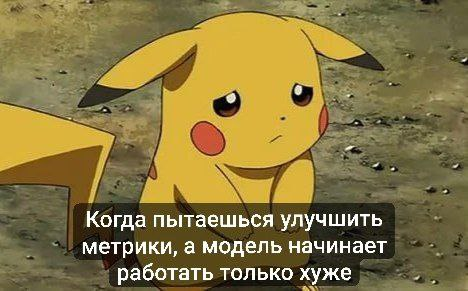